In [1]:
from cpymad.madx import Madx
import xtrack as xt
import numpy as np
import bpmeth
import matplotlib.pyplot as plt

### ELENA lattice from MAD-X

In [2]:
madx = Madx()

madx.call("acc-models-elena/elena.seq")
#   Apertures:
madx.call("acc-models-elena/elena.dbx")
#   Split elements to allow inserting BPMs:
madx.call("acc-models-elena/tools/splitEle_installBPM.madx")
# call strenghts for a given scenario
madx.call("acc-models-elena/scenarios/highenergy/highenergy.str")
# define beam
madx.call("acc-models-elena/scenarios/highenergy/highenergy.beam")

madx.use("elena")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.06.25 09:49:07      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ELENA ring Sequence -> LNR

!

!

! Changelog:

! -  5/06/2018: started with Pavel''s optics

!   - cleaned up some commented lines and added some markers

!   - redefined randomly some names of the e-cool solenoids

!   - TODO: 

!      - cleanup useless lines. re-arrange markers "badly" used here and there.

!      - rename non-existing quad 631 and 626 !!!

! - 24/11/2020: adjusted structure to new standards. Still a lot of work to do to make it LDB compatible.

! - Sep 2021: moving toward LDB-compatible model

!

! TODO: probably need to work on arc lenght for dipoles to match GEODE/drawings/LDB.





/************************************************************************************/

/*            

In [3]:
line = xt.Line.from_madx_sequence(madx.sequence.elena)
line.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)

bend_fint = line["lnr.mbhek.0640.h2"].edge_exit_fint
print(f"Fringe field integral in lattice: {bend_fint}")

tw = line.twiss4d()

Converting sequence "elena":   0%|          | 0/191 [00:00<?, ?it/s]

Fringe field integral in lattice: 0.424


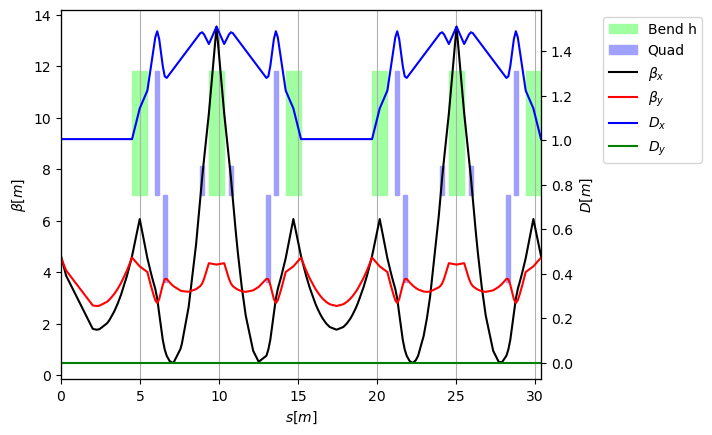

In [4]:
tw.plot()

### Numerical ELENA dipole

In [5]:
rho = 0.927
phi = 60/180*np.pi
l_magn = rho*phi
apt = 0.076
hgap = apt/2
theta_E = 17/180*np.pi
B = 5.3810e-07
Brho = B*rho

In [6]:
data = np.loadtxt("../dipole/ELENA_fieldmap.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]

Fitting multipoles
fitting b1...
Central field in the magnet:  5.373808461922011e-07
Average field in the magnet:  5.354732368951202e-07
Rescaling field to match integrated field with design field
Central field in the magnet:  1.0847506777690155
Average field in the magnet:  1.0809
Creating field expansion...
Creating Hamiltonian...


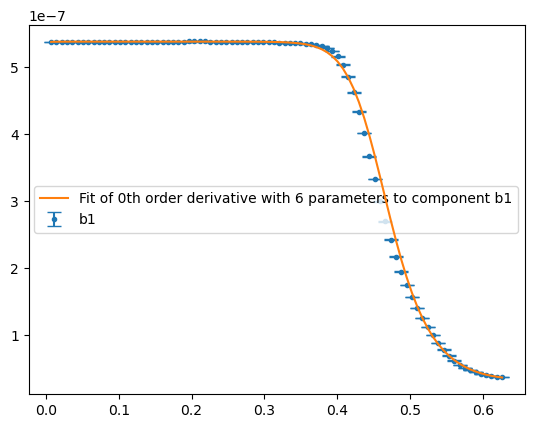

In [7]:
dipole = bpmeth.DipoleFromFieldmap(data, 1/rho, l_magn, design_field=1.0809, shape="enge", hgap=apt/2, apt=apt, radius=0.05, order=1, plot=True, nphi=2)

### Lattice without edge angles in first magnet

In [9]:
line2 = xt.Line.from_madx_sequence(madx.sequence.elena,deferred_expressions=True)
line2.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)
line2.configure_bend_model(core='adaptive', edge='full')
tw = line2.twiss4d()
print(f"{tw.qx}")
print(f"{tw.qy}")

res = {'lnr_kq1': 2.813705672068076, 'lnr_kq2': -2.0918538880765594, 'lnr_kq3': 0.38836923739266527}
for k,v in res.items():
    line2.vars[k]=v

line2['lnr.mbhek.0135.h1'].edge_entry_fint=0.0
line2['lnr.mbhek.0135.h2'].edge_exit_fint=0.0
line2['lnr.mbhek.0135.h1'].edge_entry_angle=0.0
line2['lnr.mbhek.0135.h2'].edge_exit_angle=0.0

Converting sequence "elena":   0%|          | 0/191 [00:00<?, ?it/s]

2.3616898448610883
1.3899257304100336


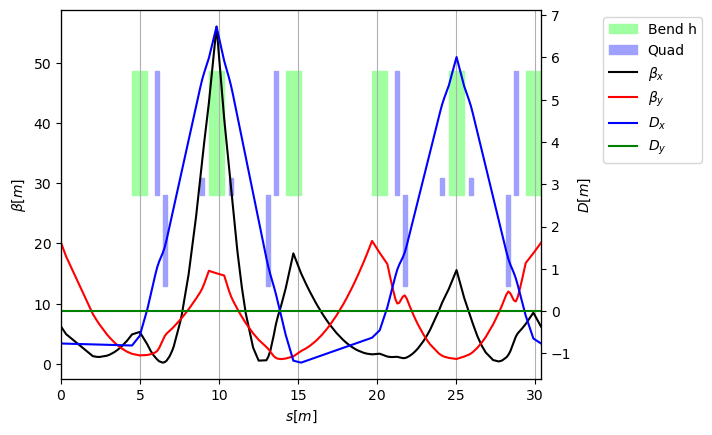

In [11]:
line2.twiss4d().plot()

### Replace a dipole

In [8]:
tab = line.get_table()
tab.show(cols=['s_start', 's_center', 's_end'])

name                          s_start      s_center         s_end
elena$start                         0             0             0
lnr.startsurvey                     0             0             0
lnr.begin                           0             0             0
section1$start                      0             0             0
drift_0                             0        0.1603        0.3206
lnr.mccay.0105                 0.3206        0.3206        0.3206
lnr.bpmeb.0110                 0.3206        0.3206        0.3206
drift_1                        0.3206       1.16575        2.0109
lnr.vvgbf.0114                 2.0109        2.0109        2.0109
drift_2                        2.0109       2.13025        2.2496
lnr.mmidinj                    2.2496        2.2496        2.2496
drift_3                        2.2496        2.3396        2.4296
lnr.mbmie.0115                 2.4296        2.4296        2.4296
drift_4                        2.4296       2.66905        2.9085
lnr.btvpa.

In [9]:
k1_edge = -line["lnr.mbhek.0135.h1"].k0*np.tan(line["lnr.mbhek.0135.h1"].edge_entry_angle)
dipole_s = line.get_s_position(at_elements="lnr.mbhek.0135.m")
dipole_len = line["lnr.mbhek.0135.h1"].length+line["lnr.mbhek.0135.h2"].length
dipole_k0 = line["lnr.mbhek.0135.h1"].k0
dipole_h = line["lnr.mbhek.0135.h1"].h

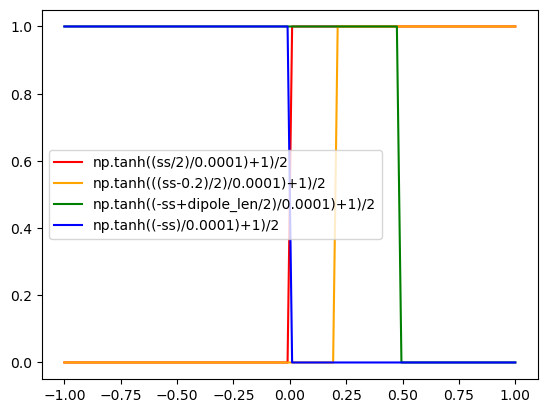

In [25]:
extent=0.2
slope=0.0001
ss = np.linspace(-1, 1, 100)
plt.plot(ss, (np.tanh((ss/2)/slope)+1)/2, color="red", label=f"np.tanh((ss/2)/{slope})+1)/2")
plt.plot(ss, (np.tanh(((ss-extent)/2)/slope)+1)/2, color="orange", label=f"np.tanh(((ss-{extent})/2)/{slope})+1)/2")
plt.plot(ss, (np.tanh((-ss+dipole_len/2)/slope)+1)/2, color="green", label=f"np.tanh((-ss+dipole_len/2)/{slope})+1)/2")
plt.plot(ss, (np.tanh((-ss)/slope)+1)/2, color="blue", label=f"np.tanh((-ss)/{slope})+1)/2")
plt.legend()

In [22]:
extent=0.2
slope = 0.0001

test_dipole_A_in1 = bpmeth.GeneralVectorPotential(b=(f"{dipole_k0} * (tanh((s-{extent})/{slope})+1)/2",), hs="0", nphi=2)
test_dipole_A_in2 = bpmeth.GeneralVectorPotential(b=(f"{dipole_k0} * (tanh((s)/{slope})+1)/2",), hs=f"{dipole_h}", nphi=2)
test_dipole_A_out1 = bpmeth.GeneralVectorPotential(b=(f"{dipole_k0} * (tanh((-s+{dipole_len/2})/{slope})+1)/2",), hs=f"{dipole_h}", nphi=2)
test_dipole_A_out2 = bpmeth.GeneralVectorPotential(b=(f"{dipole_k0} * (tanh(-s/{slope})+1)/2",), hs="0", nphi=2)
test_dipole_A_full = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0}", curv=dipole_h)

test_dipole_H_in1 = bpmeth.Hamiltonian(extent, dipole_h, test_dipole_A_in1)
test_dipole_H_in2 = bpmeth.Hamiltonian(dipole_len/2, dipole_h, test_dipole_A_in2)
test_dipole_H_out1 = bpmeth.Hamiltonian(dipole_len/2, dipole_h, test_dipole_A_out1)
test_dipole_H_out2 = bpmeth.Hamiltonian(extent, dipole_h, test_dipole_A_out2)
test_dipole_H_full = bpmeth.Hamiltonian(dipole_len, dipole_h, test_dipole_A_full)

1.0787486515641855
1.07874865156419*(-0.539374325782093*x**2 - x)/(1.07874865156419*x + 1)


In [23]:
line2 = line.copy()

line2.remove("lnr.mbhek.0135.h1")
line2.remove("lnr.mbhek.0135.m")
line2.remove("lnr.mbhek.0135.h2")
# line2.insert("mydipole", test_dipole_H_full, at=dipole_s)
line2.insert("mydipole1", test_dipole_H_in1, at=dipole_s - dipole_len/2 - extent/2)
line2.insert("mydipole2", test_dipole_H_in2, at=dipole_s - dipole_len/4)
line2.insert("mydipole3", test_dipole_H_out1, at=dipole_s + dipole_len/4)
line2.insert("mydipole4", test_dipole_H_out2, at=dipole_s + dipole_len/2 + extent/2)

# line2["lnr.mbhek.0135.h1"].edge_entry_angle = 0
# line2["lnr.mbhek.0135.h2"].edge_exit_angle = 0


line2.insert("entrance_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s-dipole_len/2)
line2.insert("exit_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s+dipole_len/2)

# To compare: line without fringes, with quadrupoles to replace edges
line3 = line.copy()

line["lnr.mbhek.0135.h1"].edge_entry_fint = 0
line["lnr.mbhek.0135.h2"].edge_exit_fint = 0

line3["lnr.mbhek.0135.h1"].edge_entry_angle = 0
line3["lnr.mbhek.0135.h2"].edge_exit_angle = 0

line3.insert("entrance_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s-dipole_len/2)
line3.insert("exit_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s+dipole_len/2)

tab2 = line2.get_table()
tab2.show(cols=['s_start', 's_center', 's_end'])

Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/201 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/202 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/200 [00:00<?, ?it/s]

name                           s_start      s_center         s_end
elena$start                          0             0             0
lnr.startsurvey                      0             0             0
lnr.begin                            0             0             0
section1$start                       0             0             0
drift_0                              0        0.1603        0.3206
lnr.mccay.0105                  0.3206        0.3206        0.3206
lnr.bpmeb.0110                  0.3206        0.3206        0.3206
drift_1                         0.3206       1.16575        2.0109
lnr.vvgbf.0114                  2.0109        2.0109        2.0109
drift_2                         2.0109       2.13025        2.2496
lnr.mmidinj                     2.2496        2.2496        2.2496
drift_3                         2.2496        2.3396        2.4296
lnr.mbmie.0115                  2.4296        2.4296        2.4296
drift_4                         2.4296       2.66905        2.

In [29]:
tw2=line2.twiss4d(betx=1, bety=1, x=0, y=0, include_collective=True)
#tw2=line2.twiss4d()
tw3=line3.twiss4d(betx=1, bety=1)

AssertionError: Some test particles were lost during twiss! (state [-1], at element [55])

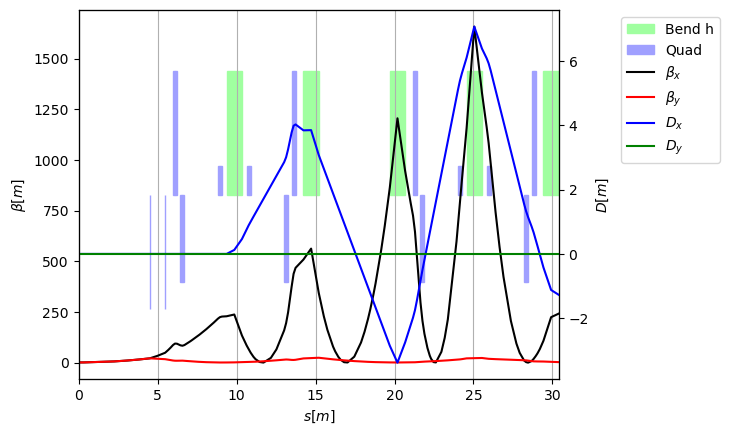

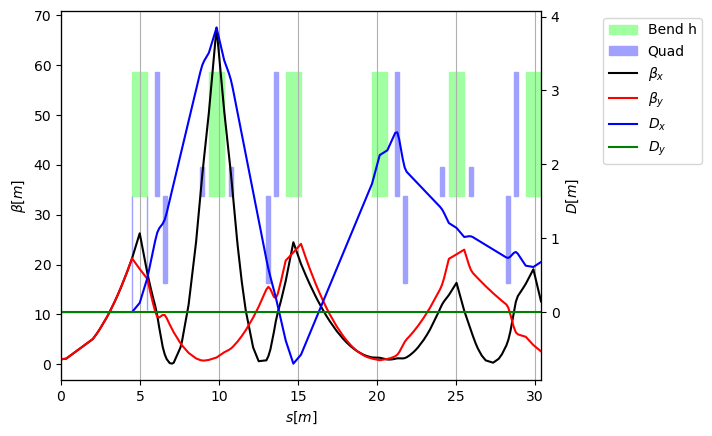

In [28]:
tw2.plot()
tw3.plot()

Dipoles:  
"lnr.mbhek.0135", "lnr.mbhek.0245", "lnr.mbhek.0335", "lnr.mbhek.0470", "lnr.mbhek.0560", "lnr.mbhek.0640"